# Creating Ontology of 311 Park Names -> official park names

This notebook creates a match dictionary between park names in 311 data and in NYC Parks official dataset. 
Using this dictionary we can match each park-related call to specific park or park District

Here I am using [fuzzywuzzy module](https://github.com/seatgeek/fuzzywuzzy)

In [137]:
__author__ = "Philipp Kats"
__date__ = "2015_10_15"

import pandas as pd
import geopandas as gp
import pylab as plt
import os
from fuzzywuzzy import process  ## fuzzy string match in python

# import json
# import numpy as np

# from geopandas.tools import sjoin
# from shapely.geometry import Point

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [138]:
PARQA = os.getenv('PARQA') #basic path

## Getting Data: both 311 Calls names and Park official names to match

In [139]:
def clean(x):
    return x.lower().replace('pool - ','').replace('playground','').strip()

In [140]:
calls = pd.DataFrame(pd.read_csv(PARQA + 'data/311/2015_10_9_311_parks.csv',encoding='utf8'))


In [141]:
callParks = calls[calls.Agency=='DPR'][['Park Facility Name',
                                                     'Borough']].drop_duplicates()

callParks['cleanName'] = callParks['Park Facility Name'].apply(clean)
print '311_call_names total:', len(callParks['Park Facility Name'])
# callParks.head(3)


311_call_names total: 1672


In [142]:
# rename Borough to BoroughCode

borrowCode = pd.DataFrame({'Borough':['BROOKLYN',
                                      'QUEENS',
                                      'MANHATTAN',
                                      'BRONX',
                                      'STATEN ISLAND',
                                      'Unspecified'],
                           'code':['B',
                                   'Q',
                                   'M',
                                   'X',
                                   'R',
                                   '?']})

callParks = callParks.merge(borrowCode, how='left', on='Borough')
callParks.head(3)

,Park Facility Name,Borough,cleanName,code
0,Ruppert Park,MANHATTAN,ruppert park,M
1,Prospect Park,BROOKLYN,prospect park,B
2,Tappen Park,STATEN ISLAND,tappen park,R


## Official Park Names

We will use official park names as a choicelist for each 311_name to choose from

In [182]:
## using geojson produced of OPEN DATA 
parkNames = gp.read_file(PARQA + 'data/parks_computed.geojson')[['SIGNNAME','BOROUGH']].drop_duplicates()
parkNames['SIGNNAME'] = parkNames['SIGNNAME'].str.lower()
len(parkNames['SIGNNAME'].drop_duplicates())

1787

In [144]:
#create a dictionary of parks for each borough 
#that will add accuracy and boost spead of search ( I hope)

ofParks = {k:[unicode(x) for x in list(v)] for k,v in parkNames.groupby("BOROUGH")["SIGNNAME"]}
ofParks['?'] = ['???'] ### to mark parks with unspecified Borough

print ofParks.keys()

[u'B', u'M', u'Q', u'R', u'X', '?']


## Matching 

As Fuzzy works quite slow, lets first match perfect ones with pd.merge function

In [179]:
callParksMatched = callParks.merge(parkNames, how='left', left_on = 'cleanName', right_on='SIGNNAME', copy=1)

In [180]:
#some manual improvisation, based on imirical experience

def impiric(x):
    'recognition, based on imirical experience'
    general = {'flushing meadows':'flushing meadows and corona park',
               'central park':'central park', 
               'prospect park':'prospect park',
               'greenbelt': 'greenbelt native plant center',
               'red hook park':'red hook recreation area',
               'crotona park':'crotona park',
               'marine park': 'marine park', 
               'van cortlandt':'van cortlandt park',
               'seravalli': 'corporal john a. seravalli playground',
               'inwood hill': 'inwood hill park',
               'forest park':'forest park',
               'pelham bay park':'pelham bay park',
               'kissena park': 'kissena park',
               'asser levy': 'asser levy park'

                }
    
    for k in general.keys():
        if k in x.cleanName:
            return general[k]

    return np.nan


# Ugly solution - don't know how to update just part of the dataframe
Unmatched = callParksMatched[pd.isnull(callParksMatched.SIGNNAME)]
Matched = callParksMatched[pd.notnull(callParksMatched.SIGNNAME)]
Unmatched.SIGNNAME = Unmatched.apply(impiric, 1)
callParksMatched = pd.concat([Matched, Unmatched])

In [181]:
Unmatched = callParksMatched[pd.isnull(callParksMatched.SIGNNAME)]
Matched = callParksMatched[pd.notnull(callParksMatched.SIGNNAME)]

print 'Unmatched: ', len(Unmatched)
print 'Matched: ', len(Matched)

Unmatched:  1087
Matched:  602


In [51]:
## function

def getBest(x):
    global ofParks
    return process.extractOne(x.cleanName, ofParks[x.code])

In [52]:
##################### MATCNING PROCESS
##################### ATTENTION !!!!!!
##################### TAKES 10 MINUTES

Unmatched['match'] = Unmatched.apply(getBest, 1)

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
Unmatched['SIGNNAME'] = Unmatched['match'].apply(lambda x: x[0])
Unmatched['ratio'] = Unmatched['match'].apply(lambda x: x[1])

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Average ratio: 85.9078233927
ratio stD: 10.7555657481


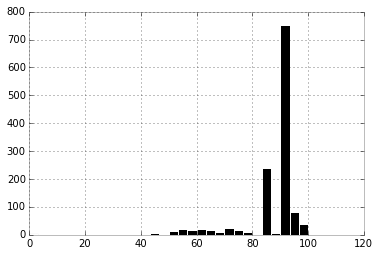

In [54]:
print 'Average ratio:', Unmatched['ratio'].mean()
print 'ratio stD:', Unmatched['ratio'].std()
Unmatched.ratio.hist(color='k', bins=30);

Yet the best option to be sure - check all candidates.

In [55]:
Unmatched[Unmatched.ratio >85].sort_values(by='ratio').head(10)

,Park Facility Name,Borough,cleanName,code,SIGNNAME,BOROUGH,match,ratio
560,Reeds Basket Willow's Swamp,STATEN ISLAND,reeds basket willow's swamp,R,reed's basket willow swamp park,NaN,"(reed's basket willow swamp park, 86)",86
109,Kissena Corridor East,QUEENS,kissena corridor east,Q,kissena corridor park,NaN,"(kissena corridor park, 86)",86
229,Ehrenreich-Austin St Playground,QUEENS,ehrenreich-austin st,Q,ehrenreich-austin playground,NaN,"(ehrenreich-austin playground, 87)",87
1487,Asser Levy Recreation Center,MANHATTAN,asser levy recreation center,M,recreation center 54,NaN,"(recreation center 54, 87)",87
1667,Highbridge Recreation Center,MANHATTAN,highbridge recreation center,M,recreation center 54,NaN,"(recreation center 54, 87)",87
290,Bealin Square and Seth Low Playground,BROOKLYN,bealin square and seth low,B,seth low playground/ bealin square,NaN,"(seth low playground/ bealin square, 87)",87
857,Floyd Patterson Field,BROOKLYN,floyd patterson field,B,floyd patterson ballfields,NaN,"(floyd patterson ballfields, 89)",89
1493,Dr Ronald E McNair Playground,BROOKLYN,dr ronald e mcnair,B,dr. ronald mcnair park,NaN,"(dr. ronald mcnair park, 89)",89
1059,Pool - MacArthur,STATEN ISLAND,macarthur,R,gen. douglas macarthur park,NaN,"(gen. douglas macarthur park, 90)",90
1061,Aqueduct Walk - Waring Playground,BRONX,aqueduct walk - waring,X,aqueduct walk,NaN,"(aqueduct walk, 90)",90


In [60]:
Matched['ratio'] = 100
JoinedD = pd.concat([Matched, Unmatched.drop('match', 1)]).sort_values(by='ratio')

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [61]:
JoinedD.head()

,Park Facility Name,Borough,cleanName,code,SIGNNAME,BOROUGH,ratio
1272,Alley Pond Park - Nature Center,Unspecified,alley pond park - nature center,?,???,NaN,0
1062,Pool - PS 46 Playground,Unspecified,ps 46,?,???,NaN,0
1021,Ten Mile River Playground,Unspecified,ten mile river,?,???,NaN,0
565,Playground 62 - PS 220,QUEENS,62 - ps 220,Q,225 street malls,NaN,38
1249,Double Nickel Playground - PS 55,STATEN ISLAND,double nickel - ps 55,R,bunker ponds park,NaN,41


In [62]:
JoinedD.describe()

,ratio
count,1689.000000
mean,89.228538
std,11.144351
min,0.000000
25%,90.000000
50%,90.000000
75%,97.000000
max,100.000000


In [63]:
JoinedD.to_csv(PARQA + 'data/matched_unmattched2_b.csv' , encoding='utf8')

## Here is manual validation part
done in Open Refine 

In [184]:
verified = pd.read_csv(PARQA + 'data/matched_unmattched_verified.csv' , encoding='utf8')
verified.head()

,Park Facility Name,Borough,cleanName,code,SIGNNAME,BOROUGH,ratio,verified
0,Alley Pond Park - Nature Center,Unspecified,alley pond park - nature center,?,???,NaN,0,False
1,Pool - PS 46 Playground,Unspecified,ps 46,?,???,NaN,0,False
2,Ten Mile River Playground,Unspecified,ten mile river,?,???,NaN,0,False
3,Playground 62 - PS 220,QUEENS,62 - ps 220,Q,225 street malls,NaN,38,False
4,Double Nickel Playground - PS 55,STATEN ISLAND,double nickel - ps 55,R,bunker ponds park,NaN,41,False


In [188]:
defined = verified[verified.verified==True]
print 'Defined totally: ',len(defined) 
print 100.0*len(defined)/len(verified), '%'

Defined totally:  1362
80.6394316163 %


In [194]:
defined.to_csv(PARQA + 'data/Ontology/defined.csv' , encoding='utf8')

In [195]:
undefined = verified[verified.verified==False].reset_index()
print undefined['Park Facility Name']

0            Alley Pond Park - Nature Center
1                    Pool - PS 46 Playground
2                  Ten Mile River Playground
3                     Playground 62 - PS 220
4           Double Nickel Playground - PS 55
5                  Mount Playground - PS 174
6                              35 Playground
7                              Playground 70
8          Francis Lewis Playground - PS 130
9                          PS 149 Playground
10                Jamaica Playground - PS 40
11            Castlewood Playground - PS 186
12                  Pool - PS 186 Playground
13              Terrapin Playground - JHS 51
14           100 Percent Playground - PS 242
15                     Israel Putnam - PS 44
16           100 Percent Playground - PS 242
17                      Sandpiper Playground
18                           Beach - Orchard
19              Terrapin Playground - JHS 51
20                        Kennedy Playground
21             Sy Seplowe Playground - PS 94
22        

In [196]:
undefined.to_csv(PARQA + 'data/Ontology/undefined.csv' , encoding='utf8')